In [1]:
#| output: false

using Pkg
Pkg.activate(dirname(@__DIR__))
Pkg.instantiate()

  Activating project at `~/Teaching/environmental-systems-analysis/website/slides`
Precompiling project...
  ✓ ChangesOfVariables
  ✓ InverseFunctions
  ✓ Ratios
  ✓ ConstructionBase
  ✓ ConcurrentUtilities
  ✓ Adapt
  ✓ TranscodingStreams
  ✓ ChainRulesCore
  ✓ DensityInterface
  ✓ FillArrays
  ✓ RecipesBase
  ✓ CodecZlib
  ✓ CodecBzip2
  ✓ Setfield
  ✓ OffsetArrays
  ✓ AbstractFFTs
  ✓ OpenSSL
  ✓ LogExpFunctions
  ✓ MutableArithmetics
  ✓ Roots
  ✓ StatsBase
  ✓ HTTP
  ✓ StaticArrays
  ✓ FFTW
  ✓ SpecialFunctions
  ✓ DiffRules
  ✓ DualNumbers
  ✓ MultivariateStats
  ✓ GR_jll
  ✓ NearestNeighbors
  ✓ HypergeometricFunctions
  ✓ Interpolations
  ✓ ColorVectorSpace
  ✓ Clustering
  ✓ GR
  ✓ ForwardDiff
  ✓ StatsFuns
  ✓ ColorSchemes
  ✓ Distributions
  ✓ KernelDensity
  ✓ PlotUtils
  ✓ RecipesPipeline
  ✓ PlotThemes
  ✓ MathOptInterface
  ✓ Plots
  ✓ HiGHS
  ✓ JuMP
  ✓ StatsPlots
  48 dependencies successfully precompiled in 130 seconds. 149 already precompiled.


In [2]:
using Plots
using LaTeXStrings

## Introduction

Systems can exhibit complex, nonlinear dynamics, including (but not limited to):

- bifurcations;
- reinforcing and dampening feedbacks; and
- tipping points.

In this notebook, we'll look at a simple model which has very complex dynamics: the shallow lake problem introduced by @Carpenter1999-wx.

## The Shallow Lake Problem

### Overview

Eutrophication is a common environmental problem in which plants and algae feed on excess nutrients and become overabundant. The large mass of plants and algae have several noxious effects on the ecosystem, including:

- hypoxia (reduction in oxygen from the decomposition of organic matter), leading to "dead zones";
- acidification (from the CO<sub>2</sub> produced by decomposition);
- reduced sunlight (from an accumulation of surface algae);
- clogged water intakes; and
- reduction in recreational value and drinking water quality.

In lakes, eutrophication is often caused by excess input of nutrients (particularly phosphorous, P), which can come from point sources (such as industrial processes) and/or non-point sources (such as agricultural runoff). As the P releases are related to economic activity, we can view this (simplified) lake management problem from the perspective of a tradeoff between economic benefits and the health of the lake: while there are benefits to the activities which lead to P releases, there are recreational, aesthetic, and ecological benefits to maintaining the lake in a non-eutrophic (or *oligotrophic*) state.

### Model Formulation

Suppose we have a town which emits phosphorous into a lake as a by-product of economic activity. The level of P in the lake at a given time $t$ is given by $X_t$ (for the purposes of this problem, we will just treat all values as dimensionless).

The level of controllable P release in year $t$ is $a_t$. The lake also receives random levels of phosphorous from non-point source runoff, which we denote by $y_t$. We model these random runoffs using a [lognormal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution) $LogNormal(\mu, \sigma^2)$, which ensures that the runoffs cannot be negative.

There is also some nutrient cycling in the lake which naturally reduces phosphorous concentrations. This cycling is the result of accumulation in the sediment and turnover (water motion disturbing the sediment and carrying the nutrients upwards) and consumers, such as mussels. This cycling is dependent on the state $X_t$, $\frac{X_t^q}{1 + X_t^q}$. The lake also loses some of its P each time period of its due to outflows and consumption, which we assume is linearly proportional to the state, $bX_t$.

![Shallow Lake Problem Diagram](../images/eutrophication-system-all.png)

As a result, the lake dynamics are given by:

$$X_{t+1} = X_t + a_t + y_t + \frac{X_t^q}{1 + X_t^q} - bX_t, \quad y_t \sim LogNormal(\mu, \sigma^2),$$

where parameter interpretation is given in the table below.

| Parameter | Definition | Units |
|:---------:|:------|:-----|
| $X_t$ | P concentration in lake | dimensionless |
| $a_t$ | point source P input | dimensionless |
| $y_t$ | non-point source P input | dimensionless |
| $q$ | P recycling rate | dimensionless |
| $b$ | rate at which P is lost | dimensionless |

: Lake problem parameters

## Lake Problem Dynamics

This analysis is adapted from @Quinn2017-vn.

First, let's look at how the balance of P recycling and outflows affects the accumulation of P in the lake absent additional inputs ($a=y=0$). 

In [3]:
# define functions for lake recycling and outflows
lake_P_cycling(x, q) = x.^q ./ (1 .+ x.^q);
lake_P_out(x, b) = b .* x;

# define range of lake states X
x = 0:0.05:2.5;


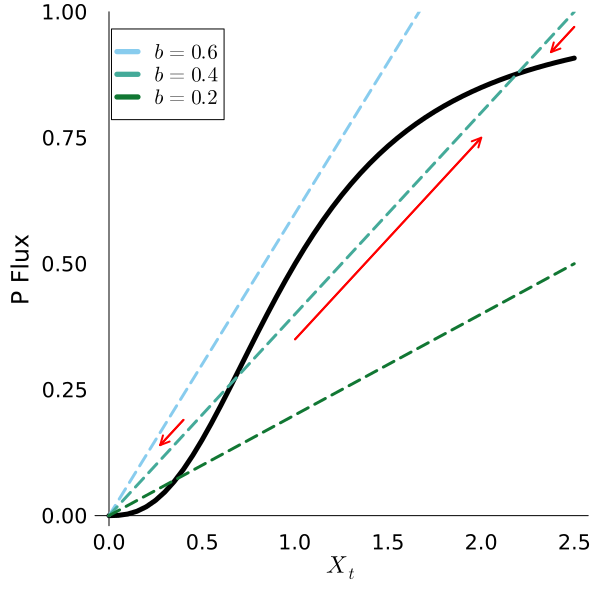

In [4]:
#| label: fig-lake-noinput
#| fig-cap: "Lake eutrophication dynamics based on the shallow lake modelwithout additional inputs. The black line is the P recycling level (for $q=2.5), which adds P back into the lake, and the dashed lines correspond to differerent rates of P outflow (based on the linear parameter $b$). The lake P level is in equilibrium when the recycling rate equals the outflows. When the outflow is greater than the recycling flux, the lake's P level decreases, and when the recycling flux is greater than the outflow, the P level naturally increases. The red lines show the direction of this net flux."
#| fig-width: 100%

# plot recycling and outflows for selected values of b and q
p1 = plot(x, lake_P_cycling(x, 2.5), color=:black, linewidth=5,legend=:topleft, label=:false, ylabel="P Flux", xlabel=L"$X_t$", tickfontsize=14, guidefontsize=16, legendfontsize=14, palette=:tol_muted, framestyle=:zerolines, grid=:false)
plot!(x, lake_P_out(x, 0.6), linewidth=3, linestyle=:dash, label=L"$b=0.6$")
plot!(x, lake_P_out(x, 0.4), linewidth=3, linestyle=:dash, label=L"$b=0.4$")
plot!(x, lake_P_out(x, 0.2), linewidth=3, linestyle=:dash, label=L"$b=0.2$")
quiver!([1], [0.35], quiver=([1], [0.4]), color=:red, linewidth=2)
quiver!([0.4], [0.19], quiver=([-0.125], [-0.05]), color=:red, linewidth=2)
quiver!([2.5], [0.97], quiver=([-0.125], [-0.05]), color=:red, linewidth=2)
plot!(ylims=(-0.02, 1))
plot!(size=(600, 600))


Based on @fig-lake-noinput, we can see that there are typically three equilibria: a stable equilibrium at $X=0$, an unstable, oligotrophic equilibrium $X_o$, and a stable, eutrophic equilibrium $X_e$. When $X_t < X_o$, the lake tends towards a zero P level without external inputs, while when $X_t > X_o$, the lake will inevitably undergo eutrophication, as the P level will tend towards $X_e$. This means that $X_t=X_o$ corresponds to a **tipping point**: beyond that level, the lake will abruptly switch to a eutrophic state from which it cannot recover.

This lake is subject to a **bifurcation** depending on the values of $b$ and $q$. To see this, let's fix $q=2.5$, as in @fig-lake-noinput. For $b=0.4$, there are the two equilibria mentioned previously. However, when $b=0.2$, there is only the unstable equilibrium $X=X_o$ in addition to $X=0$. For $b=0.6$, the only equilibrium is $X=0$, so any positive P input would result in eutrophication. This highlights the delicacy of systems which exhibit bifurcations: whether an equilibrium is stable or unstable, or even exists, can depend on a characteristic of the system which is often highly uncertain.

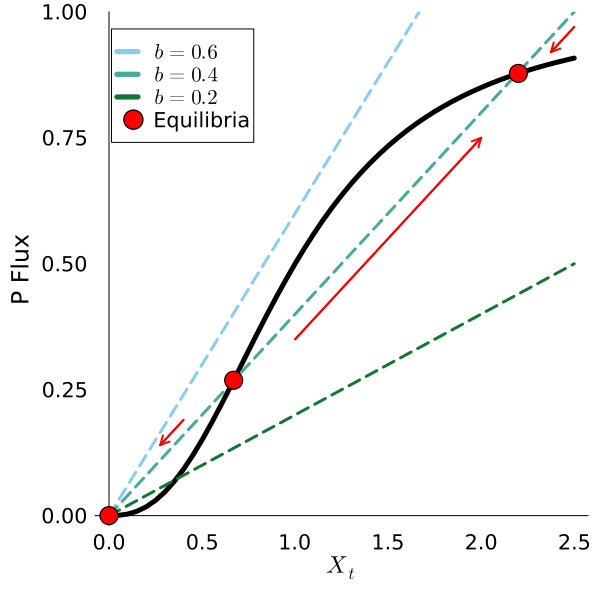

In [5]:
#| label: fig-lake-noinput-eq
#| fig-cap: "Lake eutrophication dynamics based on the shallow lake modelwithout additional inputs. The black line is the P recycling level (for $q=2.5), which adds P back into the lake, and the dashed lines correspond to differerent rates of P outflow (based on the linear parameter $b$). The lake P level is in equilibrium when the recycling rate equals the outflows. When the outflow is greater than the recycling flux, the lake's P level decreases, and when the recycling flux is greater than the outflow, the P level naturally increases. The red lines show the direction of this net flux."
#| fig-width: 100%

eq = [0, 0.67, 2.2]
scatter!(p1, eq, (y -> lake_P_cycling(y, 2.5)).(eq), label="Equilibria", markersize=10, markercolor=:red)

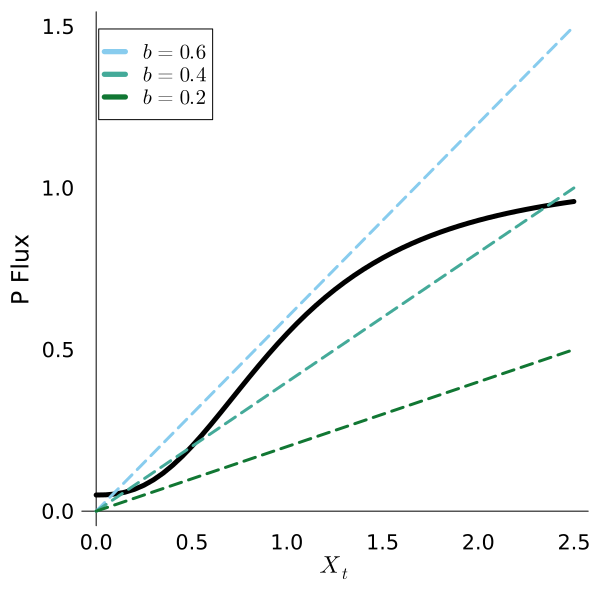

In [6]:
#| label: fig-lake-input
#| fig-cap: "Lake eutrophication dynamics based on the shallow lake model with. The black line is the P recycling level (for $q=2.5), which adds P back into the lake, and the dashed lines correspond to differerent rates of P outflow (based on the linear parameter $b$). The lake P level is in equilibrium when the recycling rate equals the outflows. When the outflow is greater than the recycling flux, the lake's P level decreases, and when the recycling flux is greater than the outflow, the P level naturally increases. The red lines show the direction of this net flux."
#| fig-width: 100%

p2 = plot(x, 0.05 .+ lake_P_cycling(x, 2.5), color=:black, linewidth=5,legend=:topleft, label=:false, ylabel="P Flux", xlabel=L"$X_t$", tickfontsize=14, guidefontsize=16, legendfontsize=14, palette=:tol_muted, framestyle=:zerolines, grid=:false)
plot!(x, lake_P_out(x, 0.6), linewidth=3, linestyle=:dash, label=L"$b=0.6$")
plot!(x, lake_P_out(x, 0.4), linewidth=3, linestyle=:dash, label=L"$b=0.4$")
plot!(x, lake_P_out(x, 0.2), linewidth=3, linestyle=:dash, label=L"$b=0.2$")
plot!(size=(600, 600))
